<a href="https://colab.research.google.com/github/lucasoteroo/IA/blob/main/2VA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prince7489/car-price-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\wands\.cache\kagglehub\datasets\prince7489\car-price-prediction-dataset\versions\1


In [44]:
# ============================
# 1) IMPORTS
# ============================
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore", module="sklearn")

# ============================
# 2) Carregar Dataframe
# ============================
csv_name = "car_price_dataset_medium.csv"
df = pd.read_csv(os.path.join(path, csv_name))
print("✔ DataFrame carregado com sucesso.")
print(df.head())
print(df.columns)


✔ DataFrame carregado com sucesso.
   Car_ID     Brand  Model_Year  Kilometers_Driven Fuel_Type Transmission  \
0       1      Audi        2005             197018    Diesel       Manual   
1       2       BMW        2019              43467    Hybrid    Automatic   
2       3       Kia        2012             153697    Hybrid    Automatic   
3       4  Mercedes        2015              38893    Petrol    Automatic   
4       5      Audi        2016              81329    Hybrid    Automatic   

  Owner_Type  Engine_CC  Max_Power_bhp  Mileage_kmpl  Seats  Price_USD  
0      First       4046          223.6         29.61      6  119611.94  
1      First       3731          248.4         21.66      5   90842.46  
2      Third       4925          465.5         12.14      6   78432.24  
3     Second       3771          229.7         19.65      6   44568.89  
4      First       2817          573.2          7.74      5    8751.82  
Index(['Car_ID', 'Brand', 'Model_Year', 'Kilometers_Driven', 'Fu

In [45]:

# ============================
# 3) Criar bins de preço
# ============================
bins = [0, 20000, 40000, np.inf]
labels = [0, 1, 2]

df["price_category"] = pd.cut(df["Price_USD"], bins=bins, labels=labels).astype(int)

print(df["price_category"])



0      2
1      2
2      2
3      2
4      0
      ..
995    2
996    2
997    2
998    2
999    2
Name: price_category, Length: 1000, dtype: int64


In [46]:

# ============================
# 4) Pré-processamento
# ============================

X = df.drop(columns=["Price_USD", "price_category", "Car_ID"])
y = df["price_category"]

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" DataFrame após get_dummies (X):")
print(X)

print("\n Dados padronizados (X_scaled):")
print(X_scaled)



 DataFrame após get_dummies (X):
     Model_Year  Kilometers_Driven  Engine_CC  Max_Power_bhp  Mileage_kmpl  \
0          2005             197018       4046          223.6         29.61   
1          2019              43467       3731          248.4         21.66   
2          2012             153697       4925          465.5         12.14   
3          2015              38893       3771          229.7         19.65   
4          2016              81329       2817          573.2          7.74   
..          ...                ...        ...            ...           ...   
995        2013             143440       3121          558.9         29.45   
996        2021              90436       1295          437.8         10.01   
997        2015              51403       4595          274.6         10.38   
998        2011              96170       2948          329.7         12.30   
999        2018              14168       1356           87.2          9.32   

     Seats  Brand_BMW  Brand_F

In [47]:

# ============================
# 5) Modelos e parâmetros
# ============================
models = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [5, 10, 15]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7]}
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {"var_smoothing": [1e-9, 1e-8]}
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "params": {"C": [0.1, 1, 10]}
    },
    "MLPClassifier": {
        "model": MLPClassifier(
            solver='adam',
            max_iter=3000,
            early_stopping=True,
            random_state=42
        ),
        "params": {"hidden_layer_sizes": [(50,), (100,), (50, 50)]}
    }
}



In [48]:

# ============================
# 6) 10-fold Stratified CV
# ============================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []

for name, mp in models.items():
    model = mp["model"]
    for param_name in mp["params"]:
        for param_value in mp["params"][param_name]:
            model.set_params(**{param_name: param_value})

            scores = cross_validate(
                model, X_scaled, y, cv=skf,
                scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"]
            )

            results.append({
                "Model": name,
                "Param": f"{param_name}={param_value}",
                "Accuracy_mean": np.mean(scores["test_accuracy"]),
                "Accuracy_std": np.std(scores["test_accuracy"]),
                "Precision_mean": np.mean(scores["test_precision_macro"]),
                "Precision_std": np.std(scores["test_precision_macro"]),
                "Recall_mean": np.mean(scores["test_recall_macro"]),
                "Recall_std": np.std(scores["test_recall_macro"]),
                "F1_mean": np.mean(scores["test_f1_macro"]),
                "F1_std": np.std(scores["test_f1_macro"])
            })


df_results = pd.DataFrame(results)
print(df_results)



                 Model                        Param  Accuracy_mean  \
0         DecisionTree                  max_depth=5          0.644   
1         DecisionTree                 max_depth=10          0.576   
2         DecisionTree                 max_depth=15          0.532   
3                  KNN                n_neighbors=3          0.524   
4                  KNN                n_neighbors=5          0.540   
5                  KNN                n_neighbors=7          0.582   
6           GaussianNB          var_smoothing=1e-09          0.526   
7           GaussianNB          var_smoothing=1e-08          0.526   
8   LogisticRegression                        C=0.1          0.659   
9   LogisticRegression                          C=1          0.657   
10  LogisticRegression                         C=10          0.657   
11       MLPClassifier     hidden_layer_sizes=(50,)          0.649   
12       MLPClassifier    hidden_layer_sizes=(100,)          0.650   
13       MLPClassifi

In [49]:

# ============================
# 7) Resultados ordenados
# ============================
df_results_sorted = df_results.sort_values(by="F1_mean", ascending=False)
print(df_results_sorted)



                 Model                        Param  Accuracy_mean  \
2         DecisionTree                 max_depth=15          0.532   
6           GaussianNB          var_smoothing=1e-09          0.526   
7           GaussianNB          var_smoothing=1e-08          0.526   
3                  KNN                n_neighbors=3          0.524   
1         DecisionTree                 max_depth=10          0.576   
4                  KNN                n_neighbors=5          0.540   
5                  KNN                n_neighbors=7          0.582   
0         DecisionTree                  max_depth=5          0.644   
11       MLPClassifier     hidden_layer_sizes=(50,)          0.649   
13       MLPClassifier  hidden_layer_sizes=(50, 50)          0.649   
12       MLPClassifier    hidden_layer_sizes=(100,)          0.650   
8   LogisticRegression                        C=0.1          0.659   
9   LogisticRegression                          C=1          0.657   
10  LogisticRegressi

# Gráfico comparativo por modelo.
O gráfico a seguir apresenta a média das métricas de cada algoritmo considerando todas as combinações de hiperparâmetros testadas. Ele permite visualizar o comportamento geral de cada modelo.

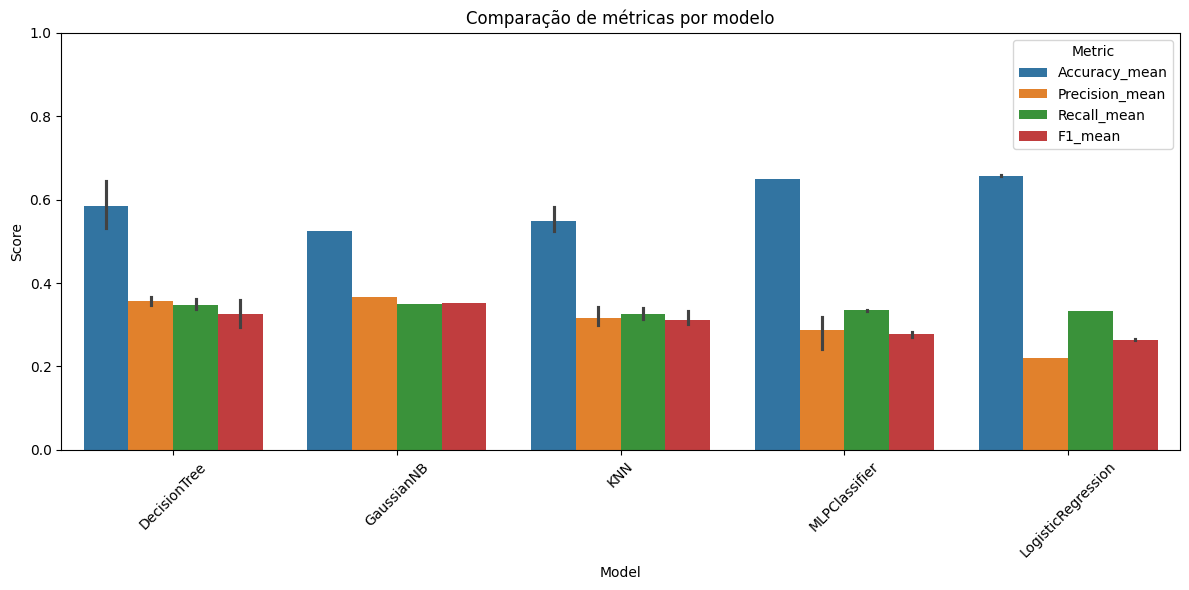

In [50]:

# ============================
# 8) Gráfico comparativo
# ============================
plt.figure(figsize=(12, 6))
metrics = ["Accuracy_mean", "Precision_mean", "Recall_mean", "F1_mean"]

df_melted = df_results_sorted.melt(
    id_vars=["Model", "Param"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Score"
)

sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
plt.title("Comparação de métricas por modelo")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Entretanto, para a escolha do melhor modelo, foi realizada a análise individual de cada combinação de parâmetros (conforme exigido no procedimento experimental), utilizando a tabela df_results, que identifica diretamente o maior F1_macro obtido dentre todas as configurações avaliadas.
Assim, o gráfico auxilia na comparação qualitativa entre algoritmos, enquanto a seleção do melhor modelo utiliza a ordenação completa dos resultados por F1_macro.

In [59]:
best_row = df_results_sorted.iloc[0]
best_row


Model             DecisionTree
Param             max_depth=15
Accuracy_mean            0.532
Accuracy_std          0.055281
Precision_mean        0.365982
Precision_std         0.065893
Recall_mean           0.361581
Recall_std            0.057696
F1_mean               0.359263
F1_std                 0.05939
Name: 2, dtype: object

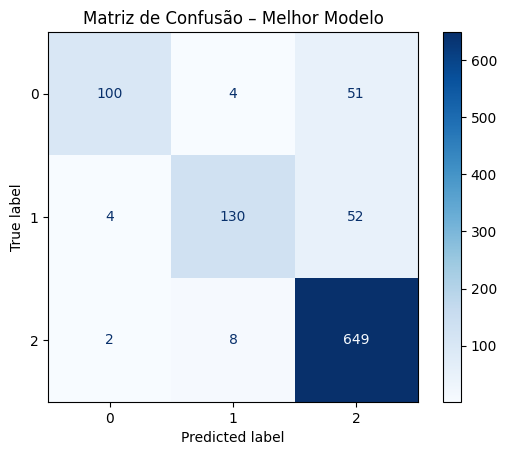

In [60]:
best_model_name = best_row["Model"]
param_str = best_row["Param"]

param_name, param_value = param_str.split("=")
param_value = eval(param_value)


model = models[best_model_name]["model"]
model.set_params(**{param_name: param_value})
model.fit(X_scaled, y)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_scaled)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – Melhor Modelo")
plt.show()


# Interpretação da Matriz de Confusão do Melhor Modelo

A matriz de confusão revela o comportamento do melhor modelo identificado pela validação cruzada estratificada. Observa-se que o modelo apresenta bom desempenho na classificação das três categorias de preço, especialmente na classe 2 (carros mais caros), que possui maior número de exemplos no conjunto de dados.

A classe 2 apresenta 649 classificações corretas e apenas pequenos erros (2 como classe 0 e 8 como classe 1), o que indica que o modelo aprendeu bem os padrões dessa categoria. Nas classes 0 e 1, embora haja acertos majoritários (100 e 130 acertos, respectivamente), também são observados erros relevantes, principalmente a confusão entre classes 0 e 2, e entre classes 1 e 2. Essa confusão pode ser explicada tanto pela menor quantidade de exemplos nas classes 0 e 1 quanto pela baixa correlação entre os atributos preditores, evidenciada no heatmap da análise exploratória.

De forma geral, a matriz confirma que o modelo realiza a tarefa de classificação multiclasses de maneira razoável, com desempenho superior nas categorias com maior volume de dados. Ela também evidencia o impacto do desbalanceamento entre as classes, reforçando a importância da validação estratificada e do uso de métricas macro para avaliação mais justa do desempenho.

In [39]:


# ============================
# 9) Salvar bases
# ============================

# Base original
df.to_csv("cars_original.csv", index=False, encoding="utf-8")
print("✔ Base original salva como 'cars_original.csv'")

# Base processada
df_preprocessed = pd.DataFrame(X_scaled, columns=X.columns)
df_preprocessed["price_category"] = y.values

df_preprocessed.to_csv("cars_preprocessed.csv", index=False, encoding="utf-8")
print("✔ Base processada salva como 'cars_preprocessed.csv'")


✔ Base original salva como 'cars_original.csv'
✔ Base processada salva como 'cars_preprocessed.csv'
